Task 1: Exploratory Data Analysis (EDA)

Merged Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price_x          1000 non-null   float64
 7   CustomerName     1000 non-null   object 
 8   Region           1000 non-null   object 
 9   SignupDate       1000 non-null   object 
 10  ProductName      1000 non-null   object 
 11  Category         1000 non-null   object 
 12  Price_y          1000 non-null   float64
dtypes: float64(3), int64(1), object(9)
memory usage: 101.7+ KB
None

Summary Statistics:
          Quantity   TotalValue     Price_x     Price_y
count  1000.000000  1000.000000  1000

/var/folders/sf/9k7lsjjj7xbg957cdpbqccj80000gn/T/ipykernel_2446/4203427932.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=popular_products.values, y=popular_products.index, palette="viridis")


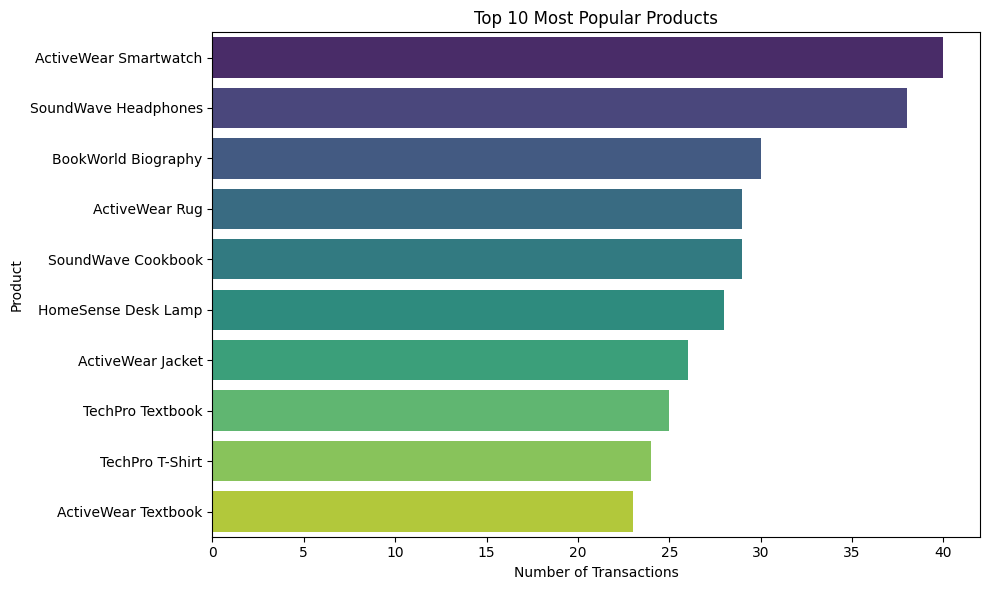

/var/folders/sf/9k7lsjjj7xbg957cdpbqccj80000gn/T/ipykernel_2446/4203427932.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_revenue.values, y=product_revenue.index, palette="rocket")


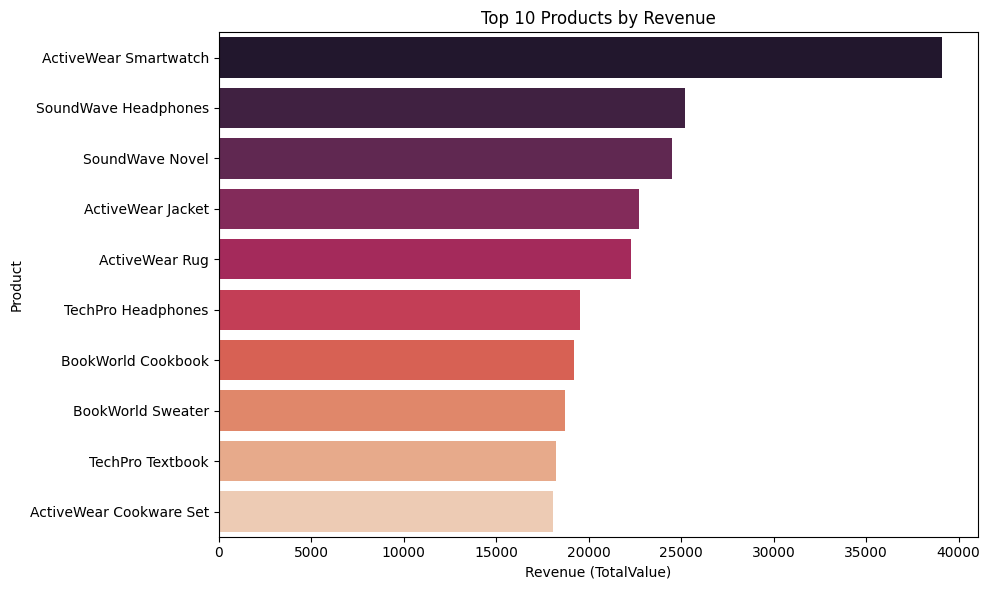

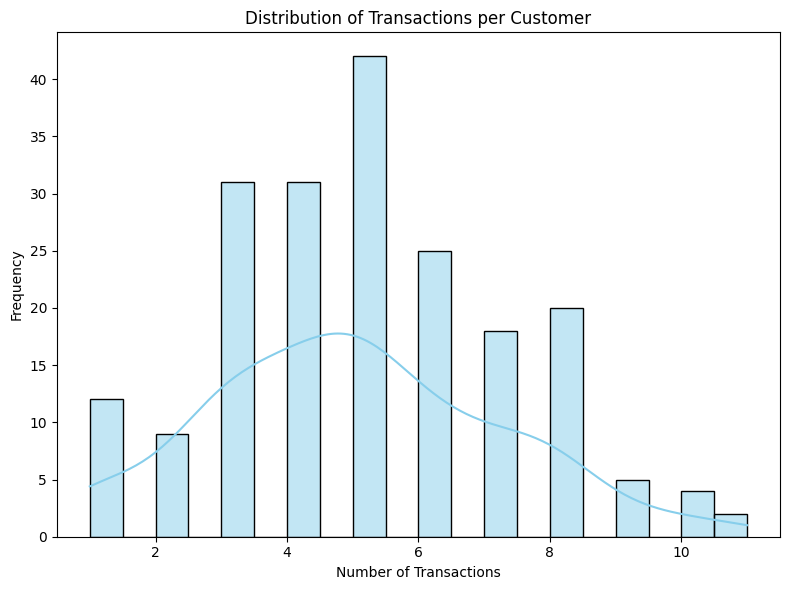

/var/folders/sf/9k7lsjjj7xbg957cdpbqccj80000gn/T/ipykernel_2446/4203427932.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_revenue.values, y=region_revenue.index, palette="magma")


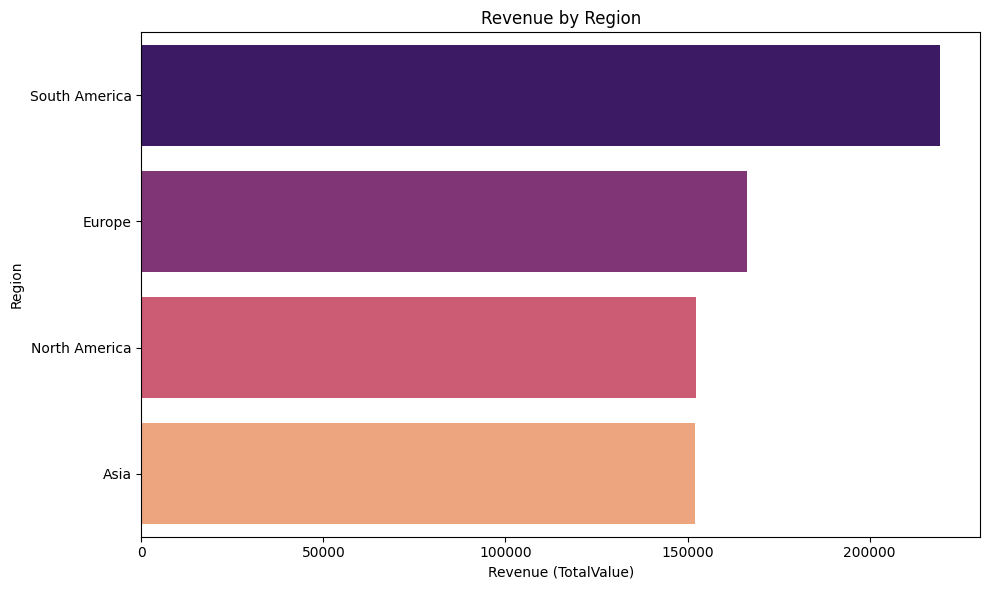


EDA Report saved as 'SaswatRanjanNayak_EDA_Report.csv'


In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv('/Users/saswatranjannayak/Desktop/Customers.csv')
products = pd.read_csv('/Users/saswatranjannayak/Desktop/Products.csv')
transactions = pd.read_csv('/Users/saswatranjannayak/Desktop/Transactions.csv')


# Merge datasets for analysis
merged_data = transactions.merge(customers, on="CustomerID", how="left").merge(products, on="ProductID", how="left")

# 1. Basic overview of the dataset
print("Merged Dataset Info:")
print(merged_data.info())
print("\nSummary Statistics:")
print(merged_data.describe())

# 2. Handling missing values
missing_values = merged_data.isnull().sum()
print("\nMissing Values:")
print(missing_values)

# 3. Most popular products
popular_products = merged_data['ProductName'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=popular_products.values, y=popular_products.index, palette="viridis")
plt.title("Top 10 Most Popular Products")
plt.xlabel("Number of Transactions")
plt.ylabel("Product")
plt.tight_layout()
plt.show()

# 4. Revenue contribution by products
product_revenue = merged_data.groupby('ProductName')['TotalValue'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=product_revenue.values, y=product_revenue.index, palette="rocket")
plt.title("Top 10 Products by Revenue")
plt.xlabel("Revenue (TotalValue)")
plt.ylabel("Product")
plt.tight_layout()
plt.show()

# 5. Customer transaction analysis
customer_transactions = merged_data['CustomerID'].value_counts()
plt.figure(figsize=(8, 6))
sns.histplot(customer_transactions, bins=20, kde=True, color="skyblue")
plt.title("Distribution of Transactions per Customer")
plt.xlabel("Number of Transactions")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 6. Revenue distribution by region
region_revenue = merged_data.groupby('Region')['TotalValue'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=region_revenue.values, y=region_revenue.index, palette="magma")
plt.title("Revenue by Region")
plt.xlabel("Revenue (TotalValue)")
plt.ylabel("Region")
plt.tight_layout()
plt.show()

# Save EDA findings to a report
eda_summary = {
    "Total Customers": customers['CustomerID'].nunique(),
    "Total Products": products['ProductID'].nunique(),
    "Total Transactions": transactions['TransactionID'].nunique(),
    "Top Product by Revenue": product_revenue.idxmax(),
    "Region with Highest Revenue": region_revenue.idxmax(),
}

eda_report = pd.DataFrame(list(eda_summary.items()), columns=["Metric", "Value"])
eda_report.to_csv('SaswatRanjanNayak_EDA_Report.csv', index=False)
print("\nEDA Report saved as 'SaswatRanjanNayak_EDA_Report.csv'")


Task 2: Lookalike Model

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load datasets
customers = pd.read_csv('/Users/saswatranjannayak/Desktop/Customers.csv')
products = pd.read_csv('/Users/saswatranjannayak/Desktop/Products.csv')
transactions = pd.read_csv('/Users/saswatranjannayak/Desktop/Transactions.csv')


# Merge the datasets
merged_data = transactions.merge(customers, on="CustomerID", how="left").merge(products, on="ProductID", how="left")

# Handle missing values
merged_data.fillna(0, inplace=True)

# Create 'Price' column if it doesn't exist
if 'Price' not in merged_data.columns:
    merged_data['Price'] = merged_data['TotalValue'] / merged_data['Quantity']

# Aggregate data for similarity calculation
lookalike_data = merged_data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum',
    'Price': 'mean'
}).reset_index()

# Standardize the numerical data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(lookalike_data[['Quantity', 'TotalValue', 'Price']])

# Calculate cosine similarity
similarity_matrix = cosine_similarity(standardized_data)

# Find top 3 lookalikes for each customer
lookalike_results = {}
for idx, customer_id in enumerate(lookalike_data['CustomerID']):
    # Get similarity scores for this customer
    similarity_scores = list(enumerate(similarity_matrix[idx]))
    # Sort by similarity score (descending) and exclude self-matching
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:4]
    # Map customer_id with top 3 similar customers and their scores
    lookalike_results[customer_id] = [(lookalike_data['CustomerID'][sim[0]], round(sim[1], 3)) for sim in similarity_scores]

# Create Lookalike.csv
lookalike_df = pd.DataFrame([
    {"CustomerID": key, "SimilarCustomers": value} for key, value in lookalike_results.items()
])
lookalike_df.to_csv('Lookalike.csv', index=False)

# Print first 20 customers (CustomerID: C0001 - C0020) and their lookalikes
print(lookalike_df.head(20))


   CustomerID                                  SimilarCustomers
0       C0001  [(C0103, 0.998), (C0092, 0.997), (C0135, 0.993)]
1       C0002    [(C0029, 1.0), (C0077, 0.996), (C0157, 0.995)]
2       C0003   [(C0111, 0.998), (C0190, 0.997), (C0038, 0.99)]
3       C0004  [(C0165, 0.998), (C0162, 0.998), (C0075, 0.997)]
4       C0005      [(C0167, 1.0), (C0020, 1.0), (C0128, 0.999)]
5       C0006  [(C0168, 0.998), (C0196, 0.995), (C0187, 0.995)]
6       C0007    [(C0125, 1.0), (C0089, 0.998), (C0085, 0.996)]
7       C0008  [(C0084, 0.996), (C0113, 0.996), (C0017, 0.993)]
8       C0009    [(C0130, 1.0), (C0128, 0.999), (C0192, 0.999)]
9       C0010  [(C0176, 0.999), (C0055, 0.994), (C0174, 0.993)]
10      C0011  [(C0023, 0.999), (C0139, 0.987), (C0100, 0.985)]
11      C0012      [(C0101, 1.0), (C0093, 1.0), (C0153, 0.999)]
12      C0013    [(C0021, 1.0), (C0141, 0.998), (C0059, 0.997)]
13      C0014  [(C0097, 0.999), (C0043, 0.997), (C0032, 0.996)]
14      C0015  [(C0058, 0.999), (C0186, 

Task 3: Customer Segmentation

Optimal number of clusters: 10

Clustering results saved to 'SaswatRanjanNayak_Clusters.csv'


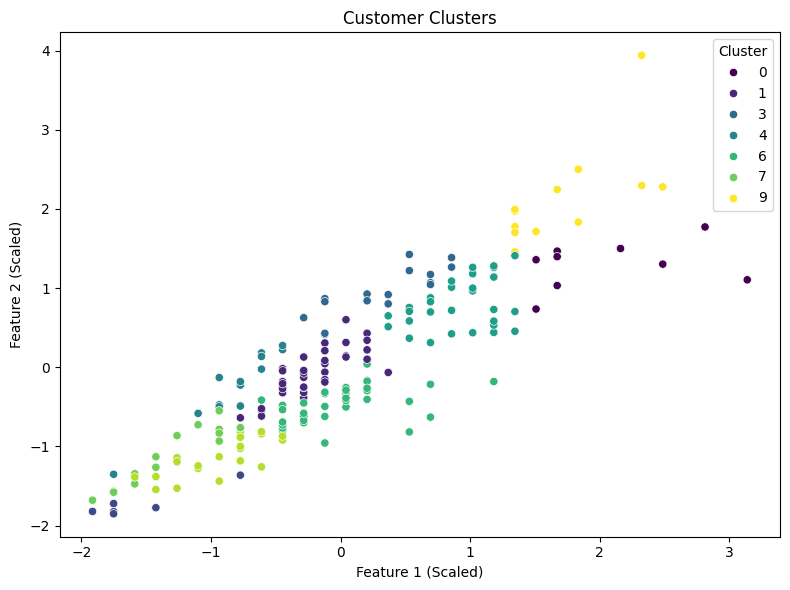

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

# Prepare data for clustering
clustering_data = merged_data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum',
    'Price': 'mean'
}).reset_index()

# Standardize data
clustering_features = scaler.fit_transform(clustering_data[['Quantity', 'TotalValue', 'Price']])

# Apply KMeans clustering
db_scores = []
for k in range(2, 11):  # Try 2 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(clustering_features)
    db_index = davies_bouldin_score(clustering_features, cluster_labels)
    db_scores.append((k, db_index))

# Optimal number of clusters
optimal_k = min(db_scores, key=lambda x: x[1])[0]
print(f"Optimal number of clusters: {optimal_k}")

# Fit KMeans with optimal clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clustering_data['Cluster'] = kmeans.fit_predict(clustering_features)

# Save cluster assignments
clustering_data.to_csv('SaswatRanjanNayak_Clusters.csv', index=False)
print("\nClustering results saved to 'SaswatRanjanNayak_Clusters.csv'")

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=clustering_features[:, 0],
    y=clustering_features[:, 1],
    hue=clustering_data['Cluster'],
    palette="viridis"
)
plt.title("Customer Clusters")
plt.xlabel("Feature 1 (Scaled)")
plt.ylabel("Feature 2 (Scaled)")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()
